### Semi-autonomous Teleoperation Demo : Place task in `Office` scene

### Parse `Realistic Scene`

In [1]:
import mujoco,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../')
from utils.mujoco_parser import MuJoCoParserClass
from utils.util import sample_xyzs,rpy2r,r2rpy,r2quat,compute_view_params,get_interp_const_vel_traj, printmd
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


In [2]:
xml_path = '../../../asset/scene_realworld_wo_shelf_fruit.xml'
env = MuJoCoParserClass(name='Place task scene: Office table',rel_xml_path=xml_path,VERBOSE=False, MODE='window')
print(env.MODE)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('avoiding_object_table').pos = np.array([0.38+0.45,0,0])
env.model.body('base').pos = np.array([-0.18,0,0.79])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-0.05,0.80,0])

# Place objects
tray_pos = np.array([ 0.9, 0.3, 0.8])
bowl_red_pos = np.array([ 0.9, 0.0, 0.8])
bowl_blue_pos = np.array([ 0.9, -0.3, 0.8])
env.model.joint(env.model.body('tray_gray').jntadr[0]).qpos0[:3] = tray_pos
env.model.joint(env.model.body('kitchen-bowl-red').jntadr[0]).qpos0[:3] = bowl_red_pos
env.model.joint(env.model.body('kitchen-bowl-blue').jntadr[0]).qpos0[:3] = bowl_blue_pos

env.model.joint(env.model.body('ycb-apple-2').jntadr[0]).qpos0[:3] = bowl_red_pos + np.array([0.0,-0.0,0.05])
env.model.joint(env.model.body('ycb-banana-2').jntadr[0]).qpos0[:3] = tray_pos + np.array([0.03,0.0,0.05])
env.model.joint(env.model.body('ycb-banana-2').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, -90])))
env.model.joint(env.model.body('ycb-lemon-2').jntadr[0]).qpos0[:3] = tray_pos + np.array([-0.03,-0.05,0.08])
env.model.joint(env.model.body('ycb-orange-2').jntadr[0]).qpos0[:3] = bowl_blue_pos + np.array([0.0,0.0,0.05])

# Target objects
env.model.joint(env.model.body('ycb-apple').jntadr[0]).qpos0[:3] = np.array([0.1, -0.6, 0.8])
env.model.joint(env.model.body('ycb-lemon').jntadr[0]).qpos0[:3] = np.array([0.0, -0.6, 0.8])
env.model.joint(env.model.body('ycb-orange').jntadr[0]).qpos0[:3] = np.array([-0.1, -0.6, 0.8])


window


In [21]:

# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=30,distance=3.0,elevation=-30,lookat=[1.0,0.0,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0

# Reset
env.reset()

# init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
init_ur_q = np.array([np.deg2rad(-180), np.deg2rad(-30), np.deg2rad(-120), np.deg2rad(125), np.deg2rad(-90), np.deg2rad(0)])

env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('tcp_link')
print(env.get_p_body('tcp_link'))
tick,max_sec = 0,1000

i = 0

while env.get_sim_time() <= max_sec:    
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    # env.model.geom_size[env.model.body('obj_box_03').geomadr[0]] += np.array([0.0001,0.0001,0.0001])
    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2] # + np.array([0,0,-0.2])
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        env.render(render_every=1)

# Close viewer
env.close_viewer()

[-0.01 -0.13  1.16]
Pressed ESC
Quitting.


In [4]:
from utils.util import fill_object, get_geom_region_type1, get_geom_region_type3

def get_geom_region_type8(env, obj_name):
    center_x, center_y, center_z, size_w, size_h, size_d = env.model.geom_aabb[env.model.body(obj_name).geomadr][0]
    obj_pos_x, obj_pos_y, obj_pos_z = env.get_p_body(obj_name)
    obj_R = env.get_R_body(obj_name)
    
    # Get the corners of the object based on the lower corner
    corners = np.array([
        # [center_x - size_w, center_y - size_h, center_z - size_d],
        # [center_x - 1*size_w, center_y - size_h, center_z + size_d],
        [center_x - size_w, center_y + size_h, center_z - size_d],
        [center_x - 1*size_w, center_y + size_h, center_z + size_d],
        # [center_x + size_w, center_y - size_h, center_z - size_d],
        # [center_x + 1*size_w, center_y - size_h, center_z + size_d],
        [center_x + size_w, center_y + size_h, center_z - size_d],
        [center_x + 1*size_w, center_y + size_h, center_z + size_d],
    ])
    
    # Consider Rotation and Translation of the obj_name
    corners = np.matmul(corners, obj_R.T) + np.array([obj_pos_x, obj_pos_y, obj_pos_z])

    return corners

resolution = (9, 9, 5)  # Number of points along each axis
obj_table_region = fill_object(get_geom_region_type3(env, 'avoiding_object_table'), resolution)
obj_tray_region = fill_object(get_geom_region_type8(env, 'tray_gray'), resolution)
obj_bowl_red_region = fill_object(get_geom_region_type1(env, 'kitchen-bowl-red'), resolution)
obj_bowl_blue_region = fill_object(get_geom_region_type1(env, 'kitchen-bowl-blue'), resolution)

stacked_geom_region = np.vstack([
    # obj_table_region, 
    obj_tray_region, obj_bowl_red_region, obj_bowl_blue_region
])

stacked_geom_region.shape

(1215, 3)

In [5]:
from utils.util import passthrough_filter, remove_duplicates_with_threshold

pcd_masked = passthrough_filter(stacked_geom_region, axis=0, interval=[0.4, 1.1])
pcd_masked = passthrough_filter(pcd_masked, axis=2, interval=[0.7, 1.3])
pcd_masked += np.array([0, 0, 0.05])
print(pcd_masked.shape)

threshold = 0.02
filtered_pcd = remove_duplicates_with_threshold(pcd_masked, threshold)
print(filtered_pcd.shape)


(1215, 3)
(135, 3)


### LLM screening

### Interact with GPT

In [6]:
import os
import openai
import sys
sys.path.append('../../../')
from utils.gpt_helper import set_openai_api_key_from_txt,GPTchatClass,printmd
from utils.wiki_helper import wiki_search
from utils.util import printmd,extract_quoted_words
print ("openai version:[%s]"%(openai.__version__))

openai version:[0.27.8]


In [7]:
import openai
openai.api_key = 'your key' 
model_name = 'gpt-3.5-turbo'#'text-davinci-002' # CaP uses text-davinci-002

class ChatGPT():
    def __init__ (self, system_prompt, model_engine='text-davinci-003'):
        self.model_engine = model_engine
        self.system_prompt = system_prompt
        self.msg_history_davinci = self.system_prompt
        self.msg_history_turbo = [{"role": "assistant", "content": self.system_prompt}]
        self.role = 'user'
    
    def reset(self):
        self.msg_history_turbo = [{"role": "assistant", "content": self.system_prompt}]

    def get_answer(self, prompt=None):
        if self.model_engine == 'gpt-3.5-turbo':
            self.msg_history_turbo.append({"role": self.role, "content":prompt})
            response   = openai.ChatCompletion.create(
            model      = self.model_engine,
            temperature= 0.9,
            messages   = self.msg_history_turbo)
            reply_text = response['choices'][0]['message']['content']
            self.msg_history_turbo.append({"role":"assistant", "content":reply_text})

        elif self.model_engine == 'text-davinci-003': 
            self.msg_history_davinci += "You: "+prompt 
            response   = openai.Completion.create(
            engine     = self.model_engine,
            prompt     = self.msg_history_davinci,
            max_tokens = 512,
            temperature= 1.0,
            n          = 1,
            #stop       = ["You:", "AI:"]
            )
            reply_text = response.choices[0].text.strip().replace('Answer: ', '')
            self.msg_history_davinci+="\n"+"AI: "+reply_text+"\n"

        elif self.model_engine == 'text-davinci-002': 
            response   = openai.Completion.create(
            engine     = self.model_engine,
            prompt     = prompt,
            max_tokens = 512,
            temperature= 1.0,
            n          = 1,
            )
            reply_text = response['choices'][0]['text'].strip()
        return reply_text



In [8]:
env.reset()

# object position lists on the table
obj_pos_list_table = {}
obj_pos_list_table['ycb-apple-2'] = {'position':env.get_p_body('ycb-apple-2'), 'size': np.array([0.03, 0.03, 0.07])}
obj_pos_list_table['ycb-banana-2'] = {'position':env.get_p_body('ycb-banana-2'), 'size': np.array([0.03, 0.03, 0.07])}
obj_pos_list_table['ycb-lemon-2'] = {'position':env.get_p_body('ycb-lemon-2'), 'size': np.array([0.03, 0.03, 0.07])}
obj_pos_list_table['ycb-orange-2'] = {'position':env.get_p_body('ycb-orange-2'), 'size': np.array([0.03, 0.03, 0.07])}
obj_pos_list_table["tray_gray"] = {'position':env.get_p_body('tray_gray'), 'size':np.array([0.24,  0.11,  0.01])}
obj_pos_list_table["kitchen-bowl-red"] = {'position':env.get_p_body('kitchen-bowl-red'), 'size':np.array([0.24,  0.11,  0.01])}

print(obj_pos_list_table)
print(list(obj_pos_list_table.keys()))

{'ycb-apple-2': {'position': array([0.9 , 0.  , 0.85]), 'size': array([0.03, 0.03, 0.07])}, 'ycb-banana-2': {'position': array([0.93, 0.3 , 0.85]), 'size': array([0.03, 0.03, 0.07])}, 'ycb-lemon-2': {'position': array([0.87, 0.25, 0.88]), 'size': array([0.03, 0.03, 0.07])}, 'ycb-orange-2': {'position': array([ 0.9 , -0.3 ,  0.85]), 'size': array([0.03, 0.03, 0.07])}, 'tray_gray': {'position': array([0.9, 0.3, 0.8]), 'size': array([0.24, 0.11, 0.01])}, 'kitchen-bowl-red': {'position': array([0.9, 0. , 0.8]), 'size': array([0.24, 0.11, 0.01])}}
['ycb-apple-2', 'ycb-banana-2', 'ycb-lemon-2', 'ycb-orange-2', 'tray_gray', 'kitchen-bowl-red']


In [9]:
object_description_list = ["kitchen-red-bowl", "kitchen-blue-bowl", "dish_gray", "table"]
target_object_name = "ycb-apple-2"

user_msg = \
    f"""
    Task description: 
    The task is to place the {target_object_name} on the table in best fit region.

    [Rules]
	1. The environment contains {list(obj_pos_list_table.keys())}. Do not invent new objects not listed here.
	2. Your plan should be as close to the provided template as possible. You can add additional information if you think it is necessary.
    3. You SHOULD answer following this format: [Recommended region: Object_Name], [Not recommended region: Object_Name]. Use ONLY the list of {object_description_list} I provided.
    3. You can say the region(area) where the object can be placed on the table. You should follow this format: [Object_Name], [Spatial_Relationship_to_the_Object], use ONLY the list of objects I provided.
	
    This is an example of instruction. For example, answer the output following instructions.

    User: Let me know which region(area) is unsuitable to place it for the same purpose. Only you can say the region.
        I want to place the {target_object_name} with the same colors. Say where is the best fit placement region?
        In the kitchen-red-bowl: [apple]
        In the kitchen-blue-bowl: [orange]
        In the gray-tray: [banana, lemon]
    GPT-4: [Recommended region: kitchen-red-bowl], [Not recommended region: kitchen-blue-bowl, gray-tray]
    If you understand, Say "I understand" and I will start the simulation.
    """

In [10]:
llm = ChatGPT(user_msg, model_engine=model_name)
llm.reset()

In [11]:
response_content = llm.get_answer(prompt=user_msg)

In [12]:
printmd(response_content)

I understand. Please wait a moment while I analyze the best fit placement region for the ycb-apple-2 object with the same colors.

After considering the colors of the objects in the environment, I recommend placing the ycb-apple-2 in the kitchen-red-bowl. The color of the apple matches well with the red bowl.

On the other hand, it is not recommended to place the ycb-apple-2 in the kitchen-blue-bowl or the gray-tray. The colors of the apple do not match with the blue bowl or the gray tray, which may not provide the desired aesthetic or visual appeal.

Therefore, the recommended region for placing the ycb-apple-2 is the kitchen-red-bowl, while the not recommended regions are the kitchen-blue-bowl and the gray-tray.

Please let me know if you need any further assistance.

In [13]:
import re
sys.path.append('../../../utils/')
from util import remove_duplicates_with_specific_com

def extract_regions(text, absent_items=None):
    recommended_pattern = r"\[Recommended region: ([^\]]+)\]"
    not_recommended_pattern = r"\[Not recommended region: ([^\]]+)\]"
    
    # Extracting the content
    recommended_match = re.search(recommended_pattern, text)
    not_recommended_match = re.search(not_recommended_pattern, text)
    
    # Parsing the content into separate lists if items are separated by commas
    recommended_lists = [item.split() for item in recommended_match.group(1).split(",")] if recommended_match else []
    not_recommended_lists = [item.split() for item in not_recommended_match.group(1).split(",")] if not_recommended_match else []

    # Removing items that are not present in the list, if specified
    if absent_items:
        not_recommended_lists = [[item for item in sublist if item not in absent_items] for sublist in not_recommended_lists]

    return recommended_lists, not_recommended_lists

# absent_items_example = ['kitchen-blue-bowl', 'dish_gray']
rec_list, not_rec_list = extract_regions(response_content, absent_items=None)
print(rec_list, not_rec_list)

[] []


In [14]:
def remove_duplicates_with_specific_com(p_com, pointcloud, threshold=0.05):
    filtered_pointcloud = []
    
    for point in pointcloud:
        # Check if the point is close to the specific center of mass (p_com)
        if np.linalg.norm(np.array(point) - np.array(p_com)) < threshold:
            filtered_pointcloud.append(point)
            
    return np.array(filtered_pointcloud)

pos_red_bowl = env.get_p_body('kitchen-bowl-red')
red_pcd = remove_duplicates_with_specific_com(pos_red_bowl, filtered_pcd, threshold=0.1)
red_pcd.shape

(19, 3)

In [15]:
feasible_pcd = np.load('./data/without_shelf/fruit/feasible_pcd_20230911_c48_g4_worker48_2.npy')
quat_range = np.load('./data/without_shelf/fruit/quat_range_20230911_c48_g4_worker48_2.npy')
# filtered_pcd = np.load('./data/without_shelf/fruit/filtered_pcd.npy')


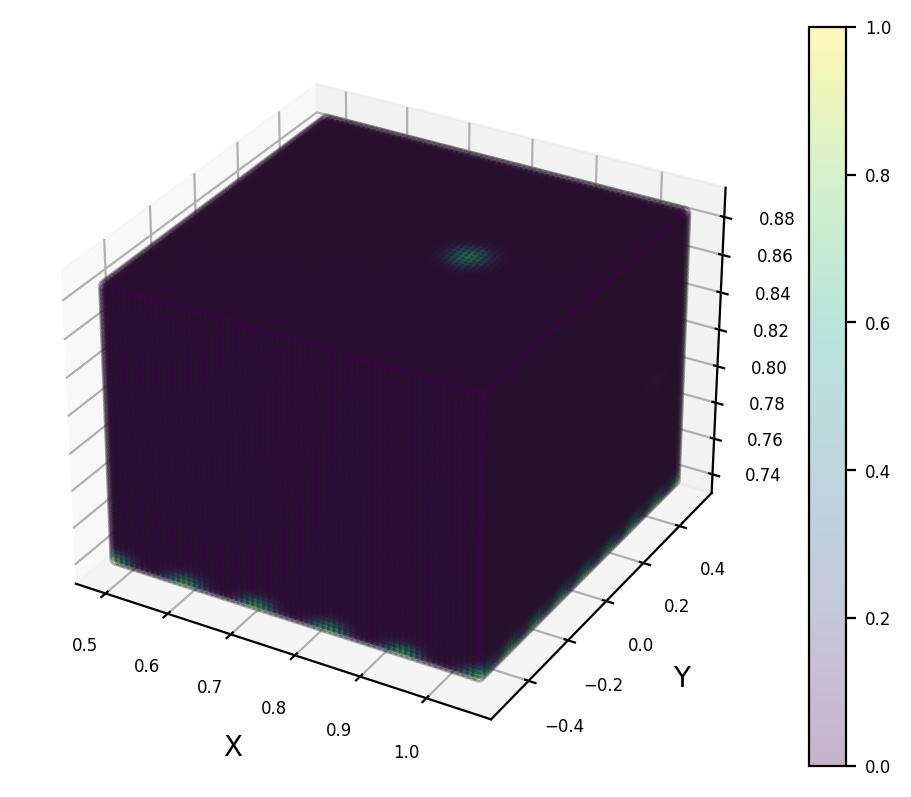

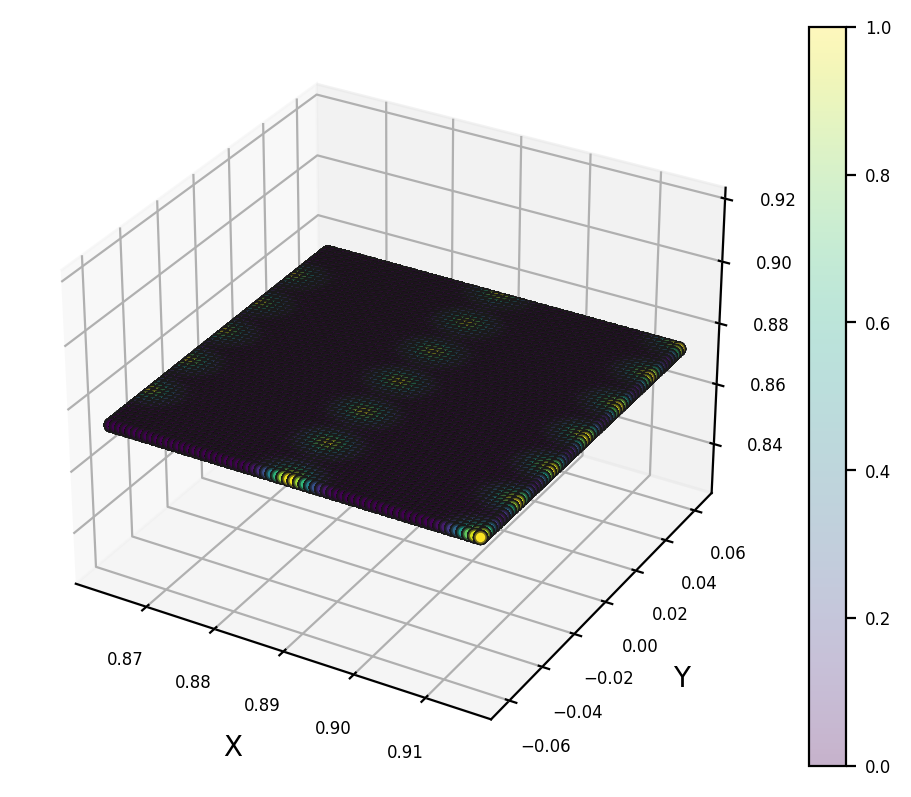

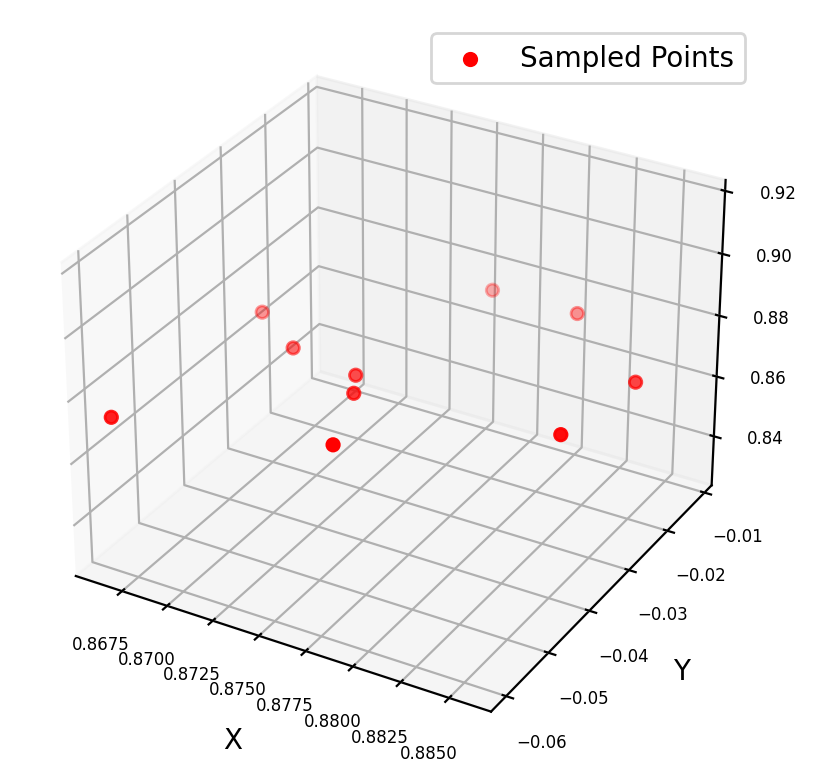

In [16]:
from scipy import stats

def sample_pcd_from_score_map(score_map, pcd, di, nbins, num_samples=10):
    score_map_flat = score_map.flatten()
    score_map_norm = score_map_flat / np.sum(score_map_flat)
    sampled_indices = np.random.choice(len(score_map_flat), size=num_samples, p=score_map_norm)
    sampled_coords = np.array(np.unravel_index(sampled_indices, di.shape)).T
    x, y, z = pcd[:, 0], pcd[:, 1], pcd[:, 2]
    x_range = np.linspace(x.min(), x.max(), nbins)
    y_range = np.linspace(y.min(), y.max(), nbins)
    z_range = np.linspace(z.min(), z.max(), nbins)
    sampled_xyz = np.array([x_range[sampled_coords[:, 0]], y_range[sampled_coords[:, 1]], z_range[sampled_coords[:, 2]]]).T
    return sampled_xyz

def get_merged_score_map(pcd1, pcd2, beta, nbins=30, bandwidth=0.1, PLOT=False, weights1=None, weights2=None):
    if weights1 is not None:
        weights1 = weights1.squeeze()

    di_normalized1, di1 = get_score_map(pcd1, nbins, bandwidth, PLOT, weights1)
    di_normalized2, di2 = get_score_map(pcd2, nbins, bandwidth, PLOT, weights2)

    # Apply weights to di1 if weights1 is provided
    if weights1 is not None:
        di1 *= weights1

    # di_merged = beta * di1 + (1 - beta) * di2
    di_merged = di2
    di_normalized_merged = di_merged / np.max(di_merged)
    return di_normalized_merged, di_merged

def get_score_map(pcd, nbins=30, bandwidth=0.1, PLOT=False, weights=None):
    x, y, z = pcd[:, 0], pcd[:, 1], pcd[:, 2]
    if weights is None:
        density = stats.gaussian_kde(pcd.T, bw_method=bandwidth)
    else:
        density = stats.gaussian_kde(pcd.T, bw_method=bandwidth, weights=weights)
    xi, yi, zi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j, z.min():z.max():nbins*1j]
    coords = np.vstack([item.ravel() for item in [xi, yi, zi]])
    di = density(coords).reshape(xi.shape)
    di_normalized = di / np.max(di)

    if PLOT:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(xi.flatten(), yi.flatten(), zi.flatten(), c=di_normalized.flatten(), cmap='viridis', edgecolor='0.1', alpha=0.3)
        plt.xlabel('X')
        plt.ylabel('Y')
        ax.set_zlabel('Z')
        plt.colorbar(scatter, ax=ax)
        plt.show()
        
    return di_normalized, di

def plot_score_map(sampled_pcd, nbins=25):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(sampled_pcd[:, 0], sampled_pcd[:, 1], sampled_pcd[:, 2], c='r', marker='o', label='Sampled Points')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()
    plt.show()

def exponential_weighting(delta_omega, alpha):
    return np.exp(alpha * np.abs(delta_omega))
def linear_weighting(delta_omega, gamma):
    return 1 + gamma * np.abs(delta_omega)

# Given parameters
bandwidth = 0.1
nbins = 68
n_samples = 10
beta = 0.2

alpha = 5
exp_weights = exponential_weighting(quat_range, alpha)
lin_weights = linear_weighting(quat_range, alpha)

merged_pcd = np.vstack([red_pcd, filtered_pcd])
merged_score_map, di_merged = get_merged_score_map(feasible_pcd, red_pcd, beta, nbins=feasible_pcd.shape[0], bandwidth=bandwidth, PLOT=True, weights1=exp_weights, weights2=None)
merged_sample = sample_pcd_from_score_map(merged_score_map, merged_pcd, di_merged, nbins=feasible_pcd.shape[0], num_samples=n_samples)

llm_score_map, di_llm = get_score_map(pcd, nbins=30, bandwidth=30, PLOT=False, weights=None)
llm_sample = sample_pcd_from_score_map(llm_score_map, red_pcd, di_llm, nbins=feasible_pcd.shape[0], num_samples=n_samples)

# plot_score_map(merged_sample, nbins=nbins)
plot_score_map(llm_sample, nbins=30)

In [17]:
env.set_figure(fig_idx=0, line_name="x", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="y", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="z", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Roll", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Pith", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Yaw", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=2, line_name="Q_w", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_x", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_y", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_z", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)

# filtered_pcd = np.load('./data/feasible_pcd_20230906_c48_g4_worker48_5.npy')

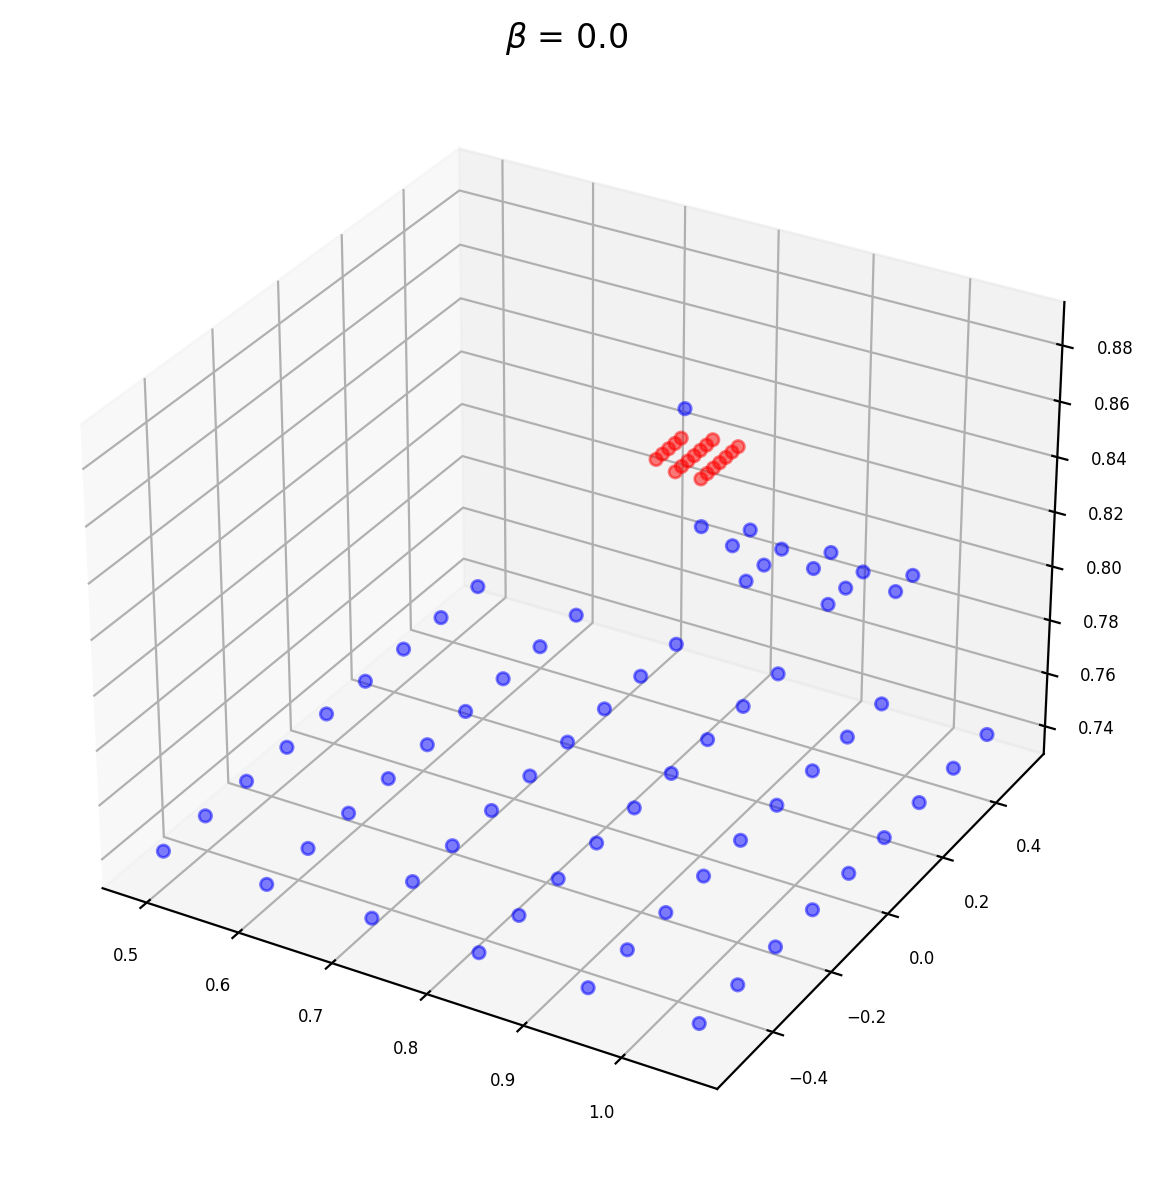

In [18]:
from scipy.stats import gaussian_kde

# Adapted function to sample from 3D KDE with debugging
def sample_from_kde_3d_debug(pcd, kde_values, num_samples=10):
    kde_values_flat = kde_values.flatten()
    kde_sum = np.sum(kde_values_flat)
    
    # Debugging: Check if the sum is zero or close to zero
    if np.isclose(kde_sum, 0):
        print(f"Warning: Sum of KDE values is close to zero ({kde_sum})")
        return None

    kde_values_norm = kde_values_flat / kde_sum
    sampled_indices = np.random.choice(len(kde_values_flat), size=num_samples, p=kde_values_norm)
    sampled_coords = np.array(np.unravel_index(sampled_indices, kde_values.shape)).T
    
    x_range = np.linspace(pcd[:, 0].min(), pcd[:, 0].max(), kde_values.shape[0])
    y_range = np.linspace(pcd[:, 1].min(), pcd[:, 1].max(), kde_values.shape[1])
    z_range = np.linspace(pcd[:, 2].min(), pcd[:, 2].max(), kde_values.shape[2])
    
    sampled_xyz = np.array([x_range[sampled_coords[:, 0]], y_range[sampled_coords[:, 1]], z_range[sampled_coords[:, 2]]]).T
    return sampled_xyz

# Generate some random 3D point clouds as an example
np.random.seed(0)
feasible_pcd = feasible_pcd
red_pcd = red_pcd

# Beta values for blending
betas = [0.0, 0.5, 1.0]
betas = [0.0]
fig = plt.figure(figsize=(24, 8))

for beta in betas:
    weights1 = np.ones(feasible_pcd.shape[0]) * beta
    weights2 = np.ones(red_pcd.shape[0]) * (1 - beta)
    
    # Ensure weights sum to 1
    total_weights = np.sum(weights1) + np.sum(weights2)
    weights1 = weights1 / total_weights
    weights2 = weights2 / total_weights
    
    merged_pcd = np.vstack([feasible_pcd, red_pcd])
    merged_weights = np.concatenate([weights1, weights2])

    # KDE computation
    merged_kde = gaussian_kde(merged_pcd.T, weights=merged_weights, bw_method=0.2)

    # Grid definition
    x_min, x_max = merged_pcd[:, 0].min(), merged_pcd[:, 0].max()
    y_min, y_max = merged_pcd[:, 1].min(), merged_pcd[:, 1].max()
    z_min, z_max = merged_pcd[:, 2].min(), merged_pcd[:, 2].max()
    
    xi, yi, zi = np.mgrid[x_min:x_max:20j, y_min:y_max:20j, z_min:z_max:20j]
    grid_coords = np.vstack([xi.ravel(), yi.ravel(), zi.ravel()])
    
    # KDE evaluation
    kde_values = merged_kde.evaluate(grid_coords).reshape(xi.shape)
    
    # Sampling with debugging
    sampled_points = sample_from_kde_3d_debug(merged_pcd, kde_values, num_samples=20)
    
    # Plotting
    ax = fig.add_subplot(1, 3, betas.index(beta) + 1, projection='3d')
    ax.scatter(feasible_pcd[:, 0], feasible_pcd[:, 1], feasible_pcd[:, 2], c='blue', alpha=0.5)
    ax.scatter(red_pcd[:, 0], red_pcd[:, 1], red_pcd[:, 2], c='red', alpha=0.5)
    
    if sampled_points is not None:
        ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], c='black', marker='x', s=100)
    
    ax.set_title(fr'$\beta$ = {beta}')
    # ax.axis('off')
plt.show()


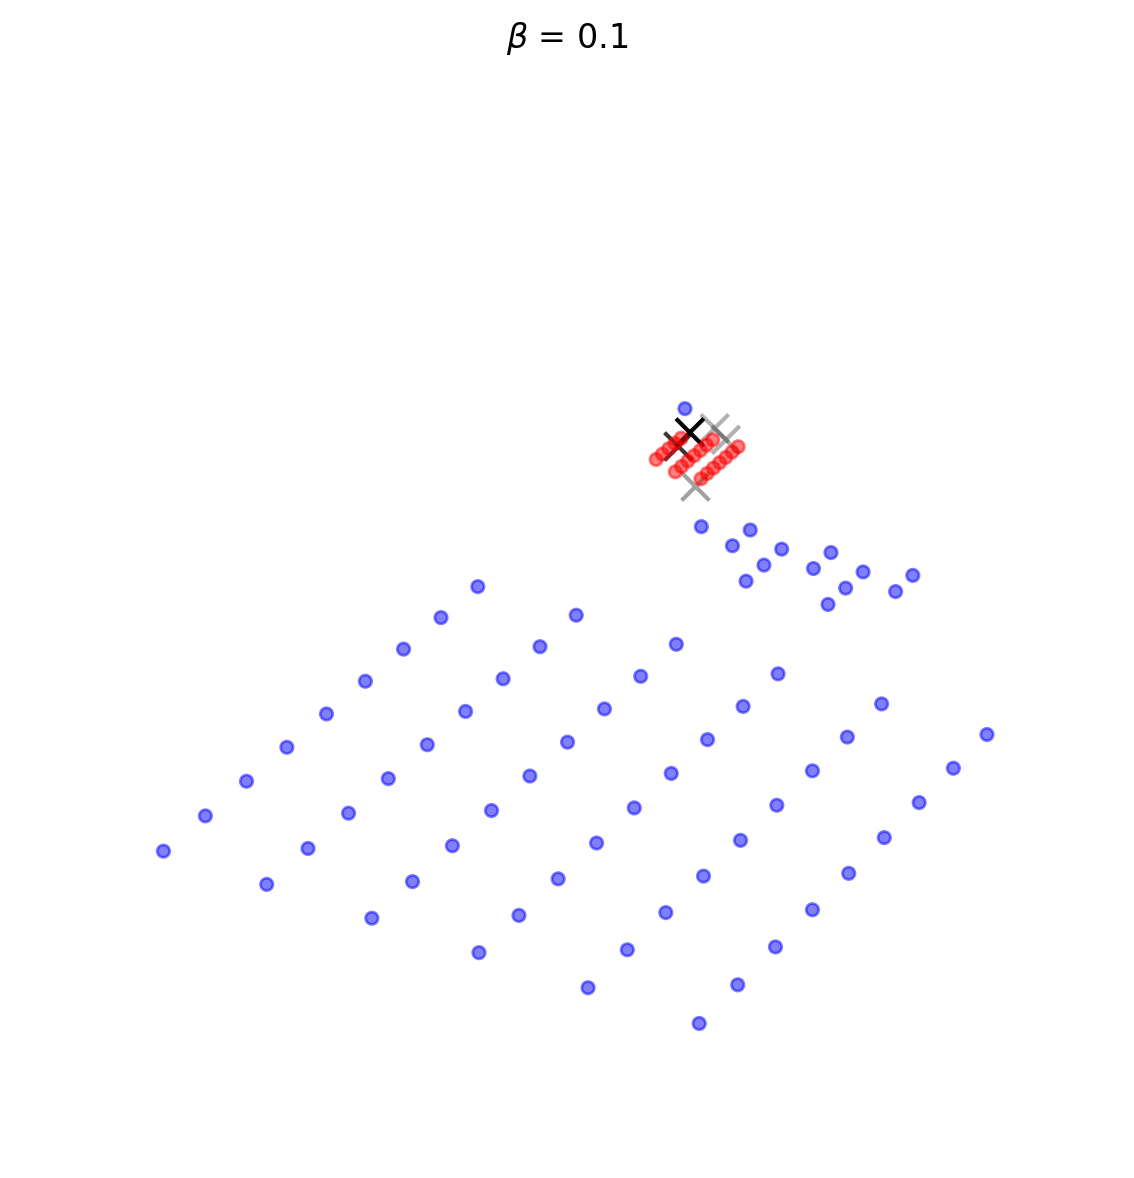

In [19]:
# Adjust the function to sample from 3D KDE with scaling and debugging
def sample_from_kde_3d_scaled(pcd, kde_values, num_samples=10):
    kde_values_flat = kde_values.flatten()
    kde_sum = np.sum(kde_values_flat)
    
    if np.isclose(kde_sum, 0):
        print(f"Warning: Sum of KDE values is close to zero ({kde_sum})")
        return None

    kde_values_norm = kde_values_flat / kde_sum
    sampled_indices = np.random.choice(len(kde_values_flat), size=num_samples, p=kde_values_norm)
    sampled_coords = np.array(np.unravel_index(sampled_indices, kde_values.shape)).T
    
    # Scale to the actual range of the data
    x_range = np.linspace(pcd[:, 0].min(), pcd[:, 0].max(), kde_values.shape[0])
    y_range = np.linspace(pcd[:, 1].min(), pcd[:, 1].max(), kde_values.shape[1])
    z_range = np.linspace(pcd[:, 2].min(), pcd[:, 2].max(), kde_values.shape[2])
    
    sampled_xyz = np.array([x_range[sampled_coords[:, 0]], y_range[sampled_coords[:, 1]], z_range[sampled_coords[:, 2]]]).T
    return sampled_xyz

# Generate some random 3D point clouds as an example
np.random.seed(0)
feasible_pcd = feasible_pcd
red_pcd = red_pcd

# Beta values for blending
betas = [0.0, 0.5, 1.0]
betas = [0.1]
fig = plt.figure(figsize=(24, 8))

for beta in betas:
    weights1 = np.ones(feasible_pcd.shape[0]) * beta
    weights2 = np.ones(red_pcd.shape[0]) * (1 - beta)
    
    total_weights = np.sum(weights1) + np.sum(weights2)
    weights1 = weights1 / total_weights
    weights2 = weights2 / total_weights
    
    merged_pcd = np.vstack([feasible_pcd, red_pcd])
    merged_weights = np.concatenate([weights1, weights2])

    # KDE computation with adjusted bandwidth
    merged_kde = gaussian_kde(merged_pcd.T, weights=merged_weights, bw_method=0.2)

    # Grid definition with finer resolution
    x_min, x_max = merged_pcd[:, 0].min(), merged_pcd[:, 0].max()
    y_min, y_max = merged_pcd[:, 1].min(), merged_pcd[:, 1].max()
    z_min, z_max = merged_pcd[:, 2].min(), merged_pcd[:, 2].max()
    
    # Increase grid resolution to 50 along each axis
    xi, yi, zi = np.mgrid[x_min:x_max:50j, y_min:y_max:50j, z_min:z_max:50j]
    grid_coords = np.vstack([xi.ravel(), yi.ravel(), zi.ravel()])
    
    # KDE evaluation
    kde_values = merged_kde.evaluate(grid_coords).reshape(xi.shape)
    
    # Sampling with debugging and scaling
    sampled_points = sample_from_kde_3d_scaled(merged_pcd, kde_values, num_samples=5)
    
    # Plotting
    ax = fig.add_subplot(1, 3, betas.index(beta) + 1, projection='3d')
    ax.scatter(feasible_pcd[:, 0], feasible_pcd[:, 1], feasible_pcd[:, 2], c='blue', alpha=0.5)
    ax.scatter(red_pcd[:, 0], red_pcd[:, 1], red_pcd[:, 2], c='red', alpha=0.5)
    
    if sampled_points is not None:
        ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], c='black', marker='x', s=100)
    
    ax.set_title(fr'$\beta$ = {beta}')
    ax.axis('off')
plt.show()


In [20]:
import time

# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0.,distance=1.5,elevation=-80,lookat=([0.44, 0.  , 1.33]),
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

env.reset()
# Start from initial configuration
capture_pose_q = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
init_configurations = [-0.73418, -1.08485, 2.7836, -1.699, 0.8366, 0]
env.forward(q=capture_pose_q,joint_idxs=[0,1,2,3,4,5])

tick = 0
end_tick = 1000
target_obj_name = 'ycb-apple' # 'coke'
target_cylinder_jntadr = env.model.body(target_obj_name).jntadr[0]
print(env.get_p_body(target_obj_name)[0])
p_list = []
R_list = []
feasible_place_positions = []
target_obj_jntadr = env.model.body(target_obj_name).jntadr[0]
target_obj_qposadr = env.model.jnt_qposadr[target_obj_jntadr]

env.set_figure(fig_idx=0, line_name="x", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="y", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="z", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Roll", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Pitch", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Yaw", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=2, line_name="Q_w", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)

for p in sampled_points:
    p_list = []
    R_list = []
    quat_list = []
    p += np.array([0, 0, 0.0])
    print(f"Position: {p}")
    start = env.tick
    p_copy = p
    env.data.qpos[target_obj_qposadr:target_obj_qposadr+3] = p_copy
    env.data.qpos[target_obj_qposadr+3:target_obj_qposadr+7] = r2quat(rpy2r(np.radians([0, 0, 0])))
    while env.tick - start < end_tick:
        env.forward(q=capture_pose_q,joint_idxs=[0,1,2,3,4,5])
        env.step(ctrl=capture_pose_q,ctrl_idxs=[0,1,2,3,4,5])
        R_obj = env.get_R_body(target_obj_name)
        quat_ = r2quat(R_obj)
        quat_list.append(quat_)
        env.plot_sphere(p=p_copy, r=0.005, rgba=[0,1,0,1], label=f"{env.tick}/{end_tick}")
        [env.plot_sphere(p=sampled_place_+[0,0,0.05], r=0.005, rgba=[0.7,0,0.7,0.1]) for sampled_place_ in sampled_points]
        # [env.plot_sphere(p=sampled_place_+[0,0,0.05], r=0.005, rgba=[0.0,0,1.0,0.1]) for sampled_place_ in feasible_pcd]
        # [env.plot_sphere(p=sampled_place_+[0,0,0.05], r=0.005, rgba=[0.0,1.0,0,0.1]) for sampled_place_ in red_pcd]

        env.plot_data(name="x", data=np.array(env.get_p_body(target_obj_name))[0], fig_idx=0)
        env.plot_data(name="y", data=np.array(env.get_p_body(target_obj_name))[1], fig_idx=0)
        env.plot_data(name="z", data=np.array(env.get_p_body(target_obj_name))[2], fig_idx=0)

        env.plot_data(name="Roll", data=r2rpy(env.get_R_body(target_obj_name))[0], fig_idx=1)
        env.plot_data(name="Pitch", data=r2rpy(env.get_R_body(target_obj_name))[1], fig_idx=1)
        env.plot_data(name="Yaw", data=r2rpy(env.get_R_body(target_obj_name))[2], fig_idx=1)
 
        env.plot_data(name="Q_w", data=env.data.qpos[target_obj_qposadr+3], fig_idx=2)

        if not env.is_viewer_alive(): break
        env.render(render_every=5)
    if not env.is_viewer_alive(): break
    env.reset()
    lower_bound = 0.70
    upper_bound = 0.79
    in_range = np.logical_and(np.array(quat_list)[5:][:,0] >= lower_bound, np.array(quat_list)[5:][:,0] <= upper_bound)
    all_in_range = np.all(in_range)
    # print(f"all_in_range: {all_in_range}")
    print(f"max_qw: {np.max(np.array(quat_list)[5:][:,0])}")
    print(f"min_qw: {np.min(np.array(quat_list)[5:][:,0])}")

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

0.1
Position: [ 0.89 -0.01  0.86]
Pressed ESC
Quitting.
Done. Tick:[805] Time:[0.80]sec


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_155613/3886366690.py:20: RuntimeWarning: invalid value encountered in divide
  kde_values_norm = kde_values_flat / np.sum(kde_values_flat)


ValueError: probabilities contain NaN

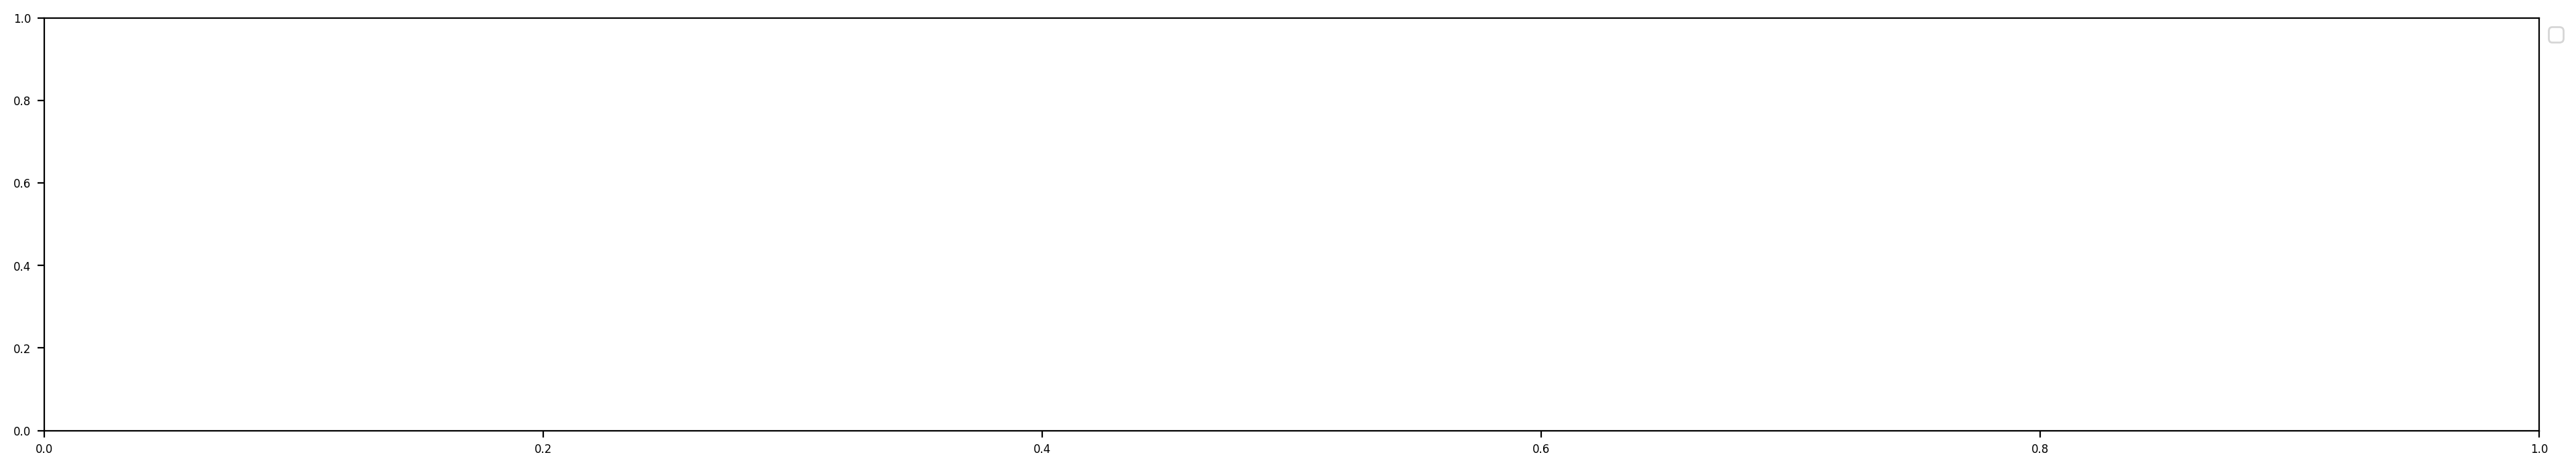

In [21]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np

def sample_from_kde(pcd, kde_values, num_samples=10):
    kde_values_flat = kde_values.flatten()
    kde_values_norm = kde_values_flat / np.sum(kde_values_flat)
    sampled_indices = np.random.choice(len(kde_values_flat), size=num_samples, p=kde_values_norm)
    sampled_coords = np.array(np.unravel_index(sampled_indices, kde_values.shape)).T

    x_range = np.linspace(pcd[:, 0].min(), pcd[:, 0].max(), kde_values.shape[0])
    y_range = np.linspace(pcd[:, 1].min(), pcd[:, 1].max(), kde_values.shape[1])
    
    sampled_xy = np.array([x_range[sampled_coords[:, 0]], y_range[sampled_coords[:, 1]]]).T

    return sampled_xy

def sample_from_kde_3d(pcd, kde_values, num_samples=10):
    kde_values_flat = kde_values.flatten()
    kde_values_norm = kde_values_flat / np.sum(kde_values_flat)
    sampled_indices = np.random.choice(len(kde_values_flat), size=num_samples, p=kde_values_norm)
    sampled_coords = np.array(np.unravel_index(sampled_indices, kde_values.shape)).T

    x_range = np.linspace(pcd[:, 0].min(), pcd[:, 0].max(), kde_values.shape[0])
    y_range = np.linspace(pcd[:, 1].min(), pcd[:, 1].max(), kde_values.shape[1])
    z_range = np.linspace(pcd[:, 2].min(), pcd[:, 2].max(), kde_values.shape[2])
    
    sampled_xyz = np.array([x_range[sampled_coords[:, 0]], y_range[sampled_coords[:, 1]], z_range[sampled_coords[:, 2]]]).T

    return sampled_xyz

pcd1 = feasible_pcd
pcd2 = red_pcd

betas = [0.0, 0.5, 1.0]

plt.figure(figsize=(24,4))
plt.legend(loc='upper left', bbox_to_anchor=(1.,1.))
for beta in betas:
    weights1 = np.ones(pcd1.shape[0]) * beta
    weights2 = np.ones(pcd2.shape[0]) * (1 - beta)
    merged_pcd = np.vstack([pcd1, pcd2])
    merged_weights = np.concatenate([weights1, weights2])

    merged_kde = gaussian_kde(merged_pcd.T, weights=merged_weights, bw_method=0.15)

    x_min, x_max = merged_pcd[:, 0].min(), merged_pcd[:, 0].max()
    y_min, y_max = merged_pcd[:, 1].min(), merged_pcd[:, 1].max()
    z_min, z_max = merged_pcd[:, 2].min(), merged_pcd[:, 2].max()
    xi, yi, zi = np.mgrid[x_min:x_max:30j, y_min:y_max:30j, z_min:z_max:30j]

    grid_coords = np.vstack([xi.ravel(), yi.ravel(), zi.ravel()])

    kde_values = merged_kde.evaluate(grid_coords).reshape(xi.shape)
    sampled_points = sample_from_kde_3d(merged_pcd, kde_values, num_samples=20)

    plt.subplot(1, 5, betas.index(beta) + 1)
    plt.contourf(xi, yi, kde_values, levels=50, cmap='viridis')
    # plt.colorbar(label='Probability Density')
    plt.scatter(pcd1[:, 0], pcd1[:, 1], c='blue', label='Feasible Points', alpha=0.1)
    plt.scatter(pcd2[:, 0], pcd2[:, 1], c='red', label='Suitable Points', alpha=0.1)
    plt.scatter(sampled_points[:, 0], sampled_points[:, 1], c='black', marker='x', label='Sampled Points', alpha=0.9, s=100)
    plt.title(fr'$\beta$ = {beta}', fontsize=25)
    plt.axis('off')
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # plt legend on it's right upper corner
plt.legend(loc='upper left', bbox_to_anchor=(1.,1.))
plt.show()


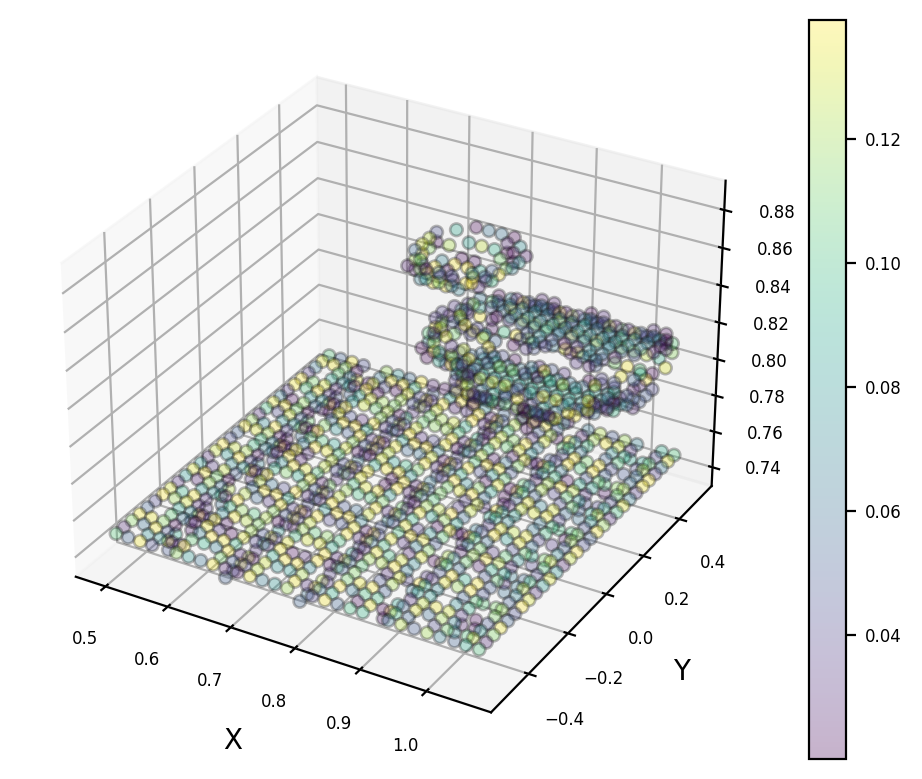

In [ ]:
def get_fused_score_map_with_weights(pcd_physics, pcd_llm, weights_physics, weights_llm, beta, nbins=30, bandwidth=0.1, PLOT=False, threshold=0.05):
    """
    Create a fused score map based on physical stability and common-sense suitability with weights.
    
    Parameters:
    - pcd_physics, pcd_llm: point clouds representing physical stability and common-sense suitability
    - weights_physics, weights_llm: weights for each point in pcd_physics and pcd_llm
    - beta: parameter to balance the two scores
    - nbins: number of bins for KDE
    - bandwidth: bandwidth for KDE
    - PLOT: whether to plot the result
    
    Returns:
    - fused_score_map: the fused score map
    """
    # Compute the KDE for physical stability
    density_physics = stats.gaussian_kde(pcd_physics.T, bw_method=bandwidth, weights=weights_physics)
    # Compute the KDE for common-sense suitability
    density_llm = stats.gaussian_kde(pcd_llm.T, bw_method=bandwidth, weights=weights_llm)
    
    x_min = min(pcd_physics[:, 0].min(), pcd_llm[:, 0].min())
    x_max = max(pcd_physics[:, 0].max(), pcd_llm[:, 0].max())
    y_min = min(pcd_physics[:, 1].min(), pcd_llm[:, 1].min())
    y_max = max(pcd_physics[:, 1].max(), pcd_llm[:, 1].max())
    z_min = min(pcd_physics[:, 2].min(), pcd_llm[:, 2].min())
    z_max = max(pcd_physics[:, 2].max(), pcd_llm[:, 2].max())
    xi, yi, zi = np.mgrid[x_min:x_max:nbins*1j, y_min:y_max:nbins*1j, z_min:z_max:nbins*1j]

    # Evaluate densities
    coords = np.vstack([item.ravel() for item in [xi, yi, zi]])
    density_values_physics = density_physics(coords).reshape(xi.shape)
    density_values_llm = density_llm(coords).reshape(xi.shape)

    if beta is None:
        fused_score_map = density_values_llm  
    elif beta == 0:
        fused_score_map = density_values_llm
    elif beta == 1:
        fused_score_map = density_values_physics
    else:
        fused_score_map = beta * density_values_physics + (1 - beta) * density_values_llm
    beta_values = 0.5 + 0.5 * np.tanh(density_values_llm - density_values_physics)
    fused_score_map = beta_values * density_values_physics + (1 - beta_values) * density_values_llm


    if PLOT:
        # Create mask to exclude zero values
        mask = fused_score_map > threshold
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(xi[mask].flatten(), yi[mask].flatten(), zi[mask].flatten(), 
                             c=fused_score_map[mask].flatten(), cmap='viridis', edgecolor='0.1', alpha=0.3)
        plt.colorbar(scatter, ax=ax)
        plt.xlabel('X')
        plt.ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()
    
    return fused_score_map

def exponential_weighting(delta_omega, alpha):
    return np.exp(alpha * np.abs(delta_omega))
def linear_weighting(delta_omega, gamma):
    return 1 + gamma * np.abs(delta_omega)

exp_weights = exponential_weighting(quat_range, alpha)
lin_weights = linear_weighting(quat_range, alpha)

pcd_1 = feasible_pcd
pcd_2 = red_pcd

# Add small noise to pcds
noisy_pcds1 = pcd_1 + np.random.normal(scale=1e-5, size=pcd_1.shape)
noisy_pcds2 = pcd_2 + np.random.normal(scale=1e-5, size=pcd_2.shape)
noisy_merged_pcds = np.vstack([noisy_pcds1, noisy_pcds2])

alpha = 1e-9
beta = 0.00001
weights_physics = exponential_weighting(quat_range, alpha).squeeze()
weights_llm = np.ones(len(pcd_2))

weights_physics *= beta
weights_llm *= (1 - beta)

fused_score_map_with_weights = get_fused_score_map_with_weights(noisy_pcds1, noisy_pcds2, weights_physics, weights_llm, beta=beta, PLOT=True, threshold=0.02)
fused_sample = sample_pcd_from_score_map(fused_score_map_with_weights, noisy_merged_pcds, di_merged, nbins=nbins, num_samples=n_samples)
llm_sample = sample_pcd_from_score_map(llm_score_map, red_pcd, di_llm, nbins=nbins, num_samples=n_samples)


In [ ]:
def sample_from_weighted_kde(kde, pcd, nbins, num_samples=10):
    # Flatten the KDE and normalize it to create a probability distribution
    kde_flat = kde.flatten()
    kde_norm = kde_flat / np.sum(kde_flat)
    
    # Sample indices based on the KDE weights
    sampled_indices = np.random.choice(len(kde_flat), size=num_samples, p=kde_norm)
    sampled_coords = np.array(np.unravel_index(sampled_indices, kde.shape)).T
    
    x_min, x_max = pcd[:, 0].min(), pcd[:, 0].max()
    y_min, y_max = pcd[:, 1].min(), pcd[:, 1].max()
    z_min, z_max = pcd[:, 2].min(), pcd[:, 2].max()
    x_range = np.linspace(x_min, x_max, nbins)
    y_range = np.linspace(y_min, y_max, nbins)
    z_range = np.linspace(z_min, z_max, nbins)
    
    sampled_points = np.array([x_range[sampled_coords[:, 0]], 
                               y_range[sampled_coords[:, 1]], 
                               z_range[sampled_coords[:, 2]]]).T
    
    return sampled_points

merged_pcd = np.concatenate((feasible_pcd, red_pcd), axis=0)

# Sample from the merged and normalized KDE
sampled_points = sample_from_weighted_kde(fused_score_map_with_weights, merged_pcd, nbins=30, num_samples=10)

sampled_points


array([[ 0.9 ,  0.51,  0.74],
       [ 0.82,  0.16,  0.8 ],
       [ 0.88, -0.44,  0.74],
       [ 0.82,  0.19,  0.81],
       [ 0.88,  0.47,  0.81],
       [ 0.71,  0.37,  0.75],
       [ 0.96,  0.23,  0.82],
       [ 0.71, -0.3 ,  0.75],
       [ 1.  ,  0.37,  0.79],
       [ 0.61,  0.09,  0.75]])

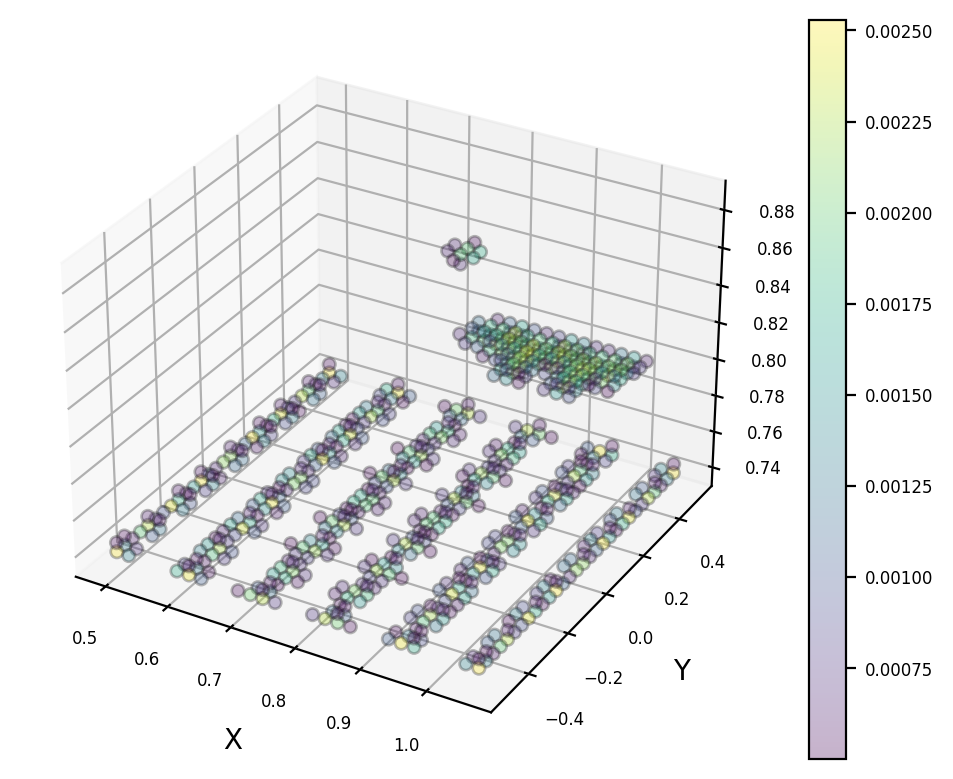

(30, 30, 30)

In [ ]:
def get_combined_normalized_score_map(pcd1, pcd2, weights1, weights2, nbins=30, bandwidth=0.1, PLOT=False, threshold=0.05):
    # Ensure weights have the same length as their respective point clouds
    if len(weights1) != len(pcd1) or len(weights2) != len(pcd2):
        raise ValueError("`weights` input should be of length n, where n is the number of points in the point cloud")
    
    # Compute the unnormalized KDEs
    density1 = stats.gaussian_kde(pcd1.T, bw_method=bandwidth, weights=weights1)
    density2 = stats.gaussian_kde(pcd2.T, bw_method=bandwidth, weights=weights2)
    
    # Create grid for evaluation
    x_min = min(pcd1[:, 0].min(), pcd2[:, 0].min())
    x_max = max(pcd1[:, 0].max(), pcd2[:, 0].max())
    y_min = min(pcd1[:, 1].min(), pcd2[:, 1].min())
    y_max = max(pcd1[:, 1].max(), pcd2[:, 1].max())
    z_min = min(pcd1[:, 2].min(), pcd2[:, 2].min())
    z_max = max(pcd1[:, 2].max(), pcd2[:, 2].max())
    xi, yi, zi = np.mgrid[x_min:x_max:nbins*1j, y_min:y_max:nbins*1j, z_min:z_max:nbins*1j]
    
    # Evaluate densities
    coords = np.vstack([item.ravel() for item in [xi, yi, zi]])
    kde_values1 = density1(coords).reshape(xi.shape)
    kde_values2 = density2(coords).reshape(xi.shape)
    
    # Combine the KDEs
    combined_kde = kde_values1 + kde_values2
    
    # Normalize the combined KDE
    normalized_combined_kde = combined_kde / np.sum(combined_kde)
    
    if PLOT:
        # Exclude zero values for plotting
        mask = normalized_combined_kde > threshold
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(xi[mask].flatten(), yi[mask].flatten(), zi[mask].flatten(), 
                             c=normalized_combined_kde[mask].flatten(), cmap='viridis', edgecolor='0.1', alpha=0.3)
        plt.colorbar(scatter, ax=ax)
        plt.xlabel('X')
        plt.ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()
    
    return normalized_combined_kde

# Example weights for each point cloud
weights1 = np.ones(len(pcd_1))
weights2 = np.ones(len(pcd_2)) * 3

# Generate the combined and normalized KDE
normalized_combined_kde = get_combined_normalized_score_map(pcd_1, pcd_2, weights1, weights2, PLOT=True, threshold=0.0005)

normalized_combined_kde.shape


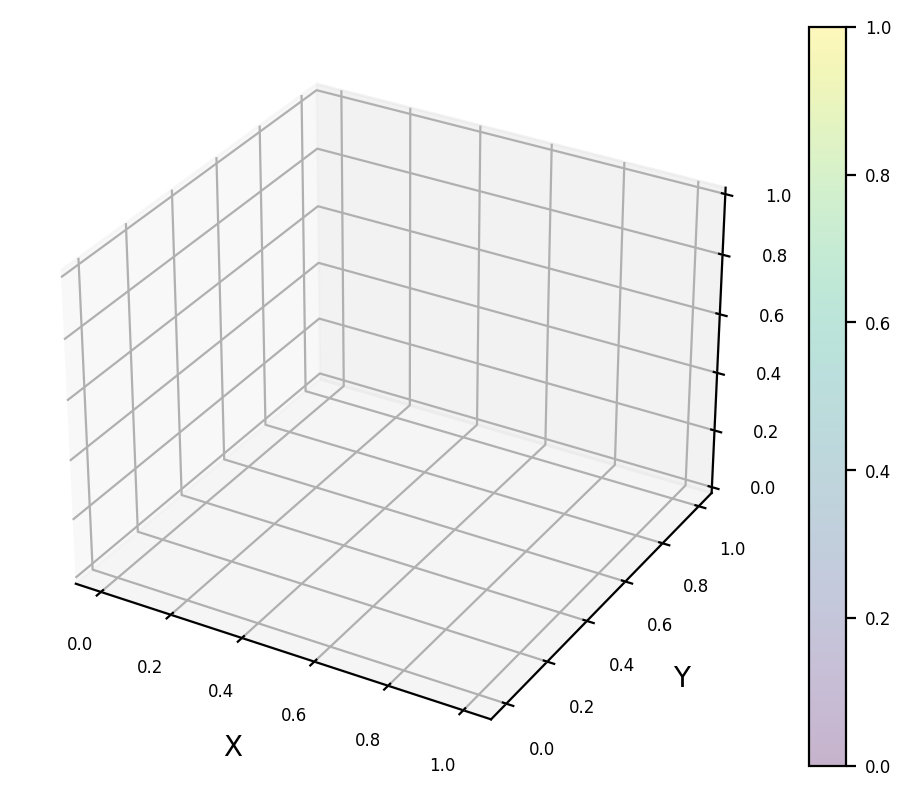

In [ ]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

def get_dynamic_beta_fused_score_map(pcd_physics, pcd_llm, weights_physics, weights_llm, nbins=30, bandwidth=0.1, PLOT=False, threshold=0.05):
    # Compute the KDE for each set of points
    density_physics = stats.gaussian_kde(pcd_physics.T, bw_method=bandwidth, weights=weights_physics)
    density_llm = stats.gaussian_kde(pcd_llm.T, bw_method=bandwidth, weights=weights_llm)
    
    # Define the grid for evaluation
    x_min = min(pcd_physics[:, 0].min(), pcd_llm[:, 0].min())
    x_max = max(pcd_physics[:, 0].max(), pcd_llm[:, 0].max())
    y_min = min(pcd_physics[:, 1].min(), pcd_llm[:, 1].min())
    y_max = max(pcd_physics[:, 1].max(), pcd_llm[:, 1].max())
    z_min = min(pcd_physics[:, 2].min(), pcd_llm[:, 2].min())
    z_max = max(pcd_physics[:, 2].max(), pcd_llm[:, 2].max())
    xi, yi, zi = np.mgrid[x_min:x_max:nbins*1j, y_min:y_max:nbins*1j, z_min:z_max:nbins*1j]
    
    # Evaluate densities
    coords = np.vstack([item.ravel() for item in [xi, yi, zi]])
    density_values_physics = density_physics(coords).reshape(xi.shape)
    density_values_llm = density_llm(coords).reshape(xi.shape)
    
    # Scale the densities with their respective weights
    adjusted_density_physics = density_values_physics * np.mean(weights_physics)
    adjusted_density_llm = density_values_llm * np.mean(weights_llm)

    # Dynamically compute beta based on adjusted densities
    beta_dynamic = adjusted_density_llm / (adjusted_density_physics + adjusted_density_llm + 1e-8)
    
    # Compute the fused score map
    fused_score_map = beta_dynamic * adjusted_density_physics + (1 - beta_dynamic) * adjusted_density_llm
    
    if PLOT:
        mask = fused_score_map > threshold
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(xi[mask].flatten(), yi[mask].flatten(), zi[mask].flatten(), 
                             c=fused_score_map[mask].flatten(), cmap='viridis', edgecolor='0.1', alpha=0.3)
        plt.colorbar(scatter, ax=ax)
        plt.xlabel('X')
        plt.ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()
    
    return fused_score_map

pcd_physics = pcd_1
pcd_llm = pcd_2
weights_physics = weights_physics
weights_llm = weights_llm

# Test the function
dynamic_fused_score_map = get_dynamic_beta_fused_score_map(pcd_physics, pcd_llm, weights_physics, weights_llm, PLOT=True, threshold=0.01)
